In [1]:
# https://github.com/skj-777/Auto-Dinette/blob/master/WasteSegregatorCNN.py

import os
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,Activation,Conv2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from keras import optimizers, regularizers, Model

from mpl_toolkits.axes_grid1 import ImageGrid

import itertools

from keras.callbacks import ModelCheckpoint

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob
import seaborn as sn

# Import OpenCV
import cv2

from os import listdir
from os.path import isfile, join 

from keras.callbacks import EarlyStopping 

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Model setting

In [2]:
IMAGE_SIZE = (256,256)
INPUT_SHAPE = (256,256,3)

BATCH_SIZE = 12
EPOCHS = 20
STEP_PER_EPOCHS = 50

### Read image dataset

In [3]:
base_dir = 'dataset_v2'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
predict_dir = os.path.join(base_dir, 'predict')

### Creating objects for image augmentations

In [4]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
 
test_datagen = ImageDataGenerator(rescale=1./255)

 
train_generator = train_datagen.flow_from_directory(train_dir,
                            target_size=IMAGE_SIZE,
                            batch_size=BATCH_SIZE,
                            class_mode='categorical')
 
test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False)

Found 1890 images belonging to 5 classes.
Found 418 images belonging to 5 classes.


### Setup model layers

In [5]:
model = Sequential()

# Step 1 - Convolution
model.add(Conv2D(32, (3, 3), input_shape = INPUT_SHAPE, activation = 'relu'))

# Step 2 - Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

# Adding a second convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))
model.add(BatchNormalization())

# Adding a third convolutional layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(BatchNormalization())

# Adding a fourth convolutional layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Step 3 - Flattening
model.add(Flatten())   
# Step 4 - Full connection
model.add(BatchNormalization())
model.add(Dense(units = 1024, activation = 'relu'))

model.add(Dense(units = 5, activation = 'softmax'))
 

In [6]:
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Fit model

In [7]:
model_history = model.fit_generator(train_generator,steps_per_epoch=STEP_PER_EPOCHS,
                    epochs=20, validation_data=test_generator, validation_steps=STEP_PER_EPOCHS,
                    callbacks=[EarlyStopping(monitor='loss', patience=5)])

Epoch 1/20
50/50 [==============================] - 98s 2s/step - loss: 1.5105 - accuracy: 0.4683 - val_loss: 1.6922 - val_accuracy: 0.1589
Epoch 2/20
50/50 [==============================] - 83s 2s/step - loss: 1.3996 - accuracy: 0.5253 - val_loss: 1.4215 - val_accuracy: 0.1672
Epoch 3/20
50/50 [==============================] - 85s 2s/step - loss: 1.3283 - accuracy: 0.5400 - val_loss: 1.6295 - val_accuracy: 0.1577
Epoch 4/20
50/50 [==============================] - 86s 2s/step - loss: 1.0371 - accuracy: 0.6217 - val_loss: 0.9780 - val_accuracy: 0.3161
Epoch 5/20
50/50 [==============================] - 96s 2s/step - loss: 1.0190 - accuracy: 0.6733 - val_loss: 3.1684 - val_accuracy: 0.2987
Epoch 6/20
50/50 [==============================] - 82s 2s/step - loss: 1.0339 - accuracy: 0.6397 - val_loss: 1.9674 - val_accuracy: 0.2776
Epoch 7/20
50/50 [==============================] - 97s 2s/step - loss: 0.8273 - accuracy: 0.7071 - val_loss: 0.9013 - val_accuracy: 0.3909
Epoch 8/20
50/50 [==

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)       

### Model accuracy and loss plots

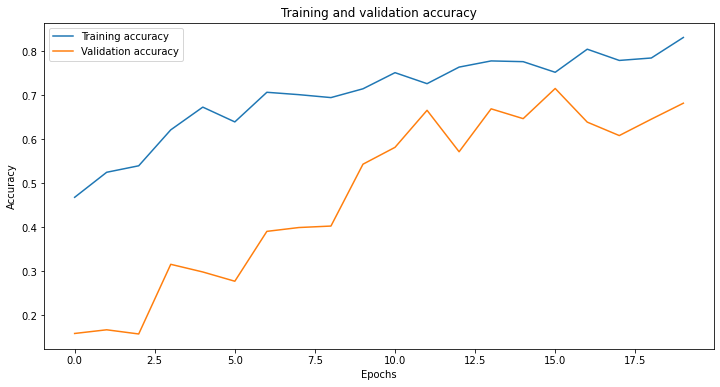

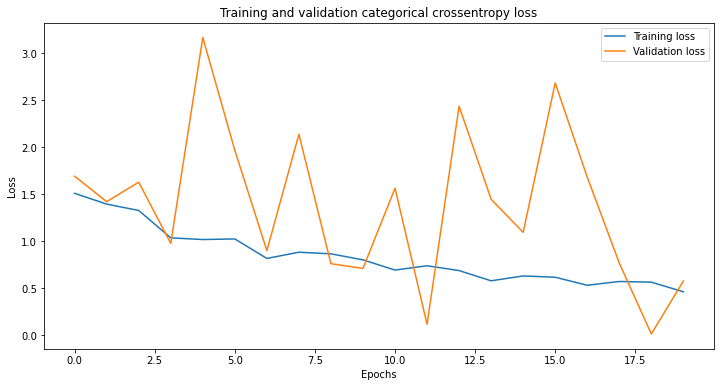

In [9]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and validation categorical crossentropy loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


model_performance_plot(model_history)

### Evaluate test dataset

In [10]:
loss, accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples//test_generator.batch_size)

In [11]:
print("Test dataset Accuracy: %f and Loss: %f" % (accuracy,loss))

Test dataset Accuracy: 0.696078 and Loss: 0.793053


### Model Classification and Confusion Matrix

In [12]:
Y_pred = model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

In [13]:
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names)) 

Classification Report
              precision    recall  f1-score   support

   cardboard       0.85      0.85      0.85       101
       glass       0.62      0.54      0.58        80
       metal       0.52      0.66      0.58        65
       paper       0.87      0.69      0.77        95
     plastic       0.58      0.68      0.63        77

    accuracy                           0.69       418
   macro avg       0.69      0.68      0.68       418
weighted avg       0.71      0.69      0.70       418



Confusion Matrix


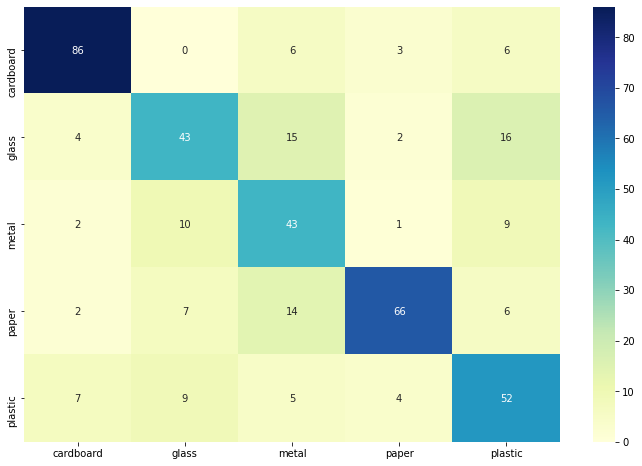

In [14]:
print('Confusion Matrix')
conf_mat = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

### Predict new images

In [15]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}

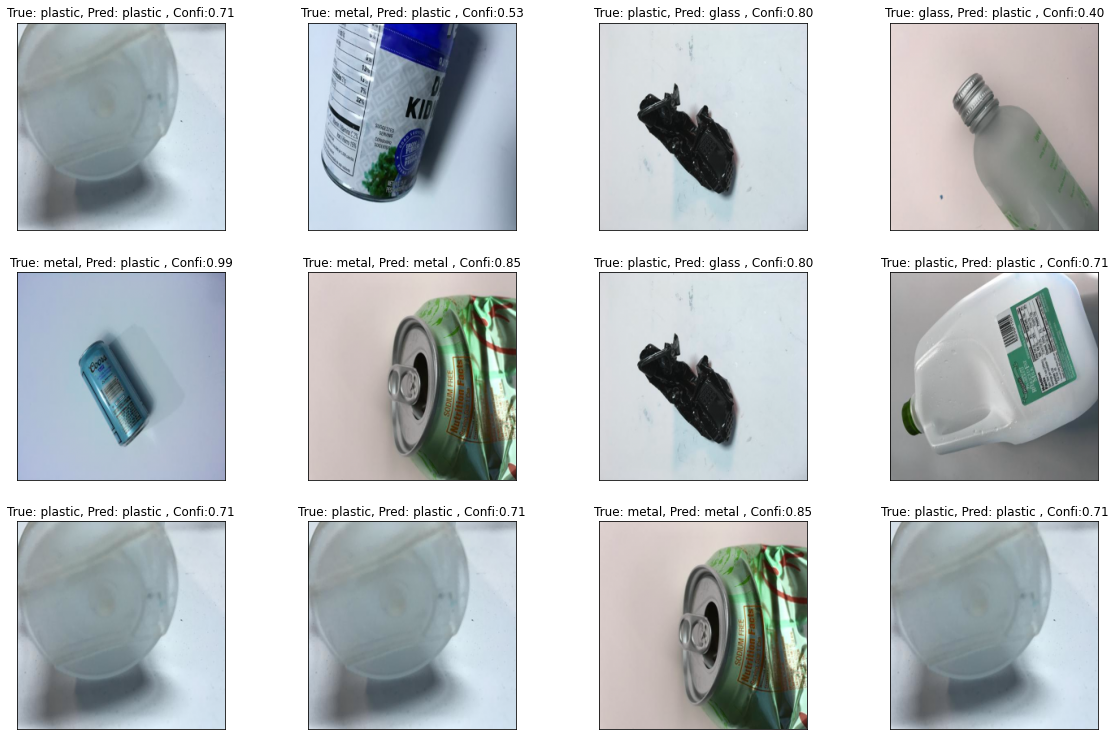

In [16]:
# Plot function

from keras.preprocessing import image

# Import OpenCV
import cv2

from os import listdir
from os.path import isfile, join 

def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    

def plot_predicted_label(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 13))
    
    rs = np.random.choice(len(onlyfiles), nrows*ncols)
    
    for i, ax in zip(rs, axes.flat):
        img = cv2.imread(os.path.join(predict_dir, onlyfiles[i]))
        true_type = image_type(onlyfiles[i])
        img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1])) 
        img = img /255
         
        probabilities = model.predict(np.asarray([img]))[0]
        class_idx = np.argmax(probabilities)
            
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,class_mapping[class_idx],probabilities[class_idx])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])
        
# ploat image with predicted and actual value
num_rows = 3
num_cols = 4

# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]

plot_predicted_label(num_rows, num_cols,onlyfiles);

### Save model

In [17]:
model.save('CNNModel.pkl')
model.save('CNNModel.h5')